In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Training and test images

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Custom Dataset class for images
class ImageDataset(Dataset):
    def __init__(self, img_dir,cup_mask_dir,disc_mask_dir, transform=None):
        self.img_dir = img_dir
        self.cup_mask_dir = cup_mask_dir
        self.disc_mask_dir = disc_mask_dir
        self.transform = transform

        self.img_names = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir,img_name)

        img_name_without_ext = img_name.split('.')[0]

        cup_mask_subdir = os.path.join(self.cup_mask_dir, img_name_without_ext)
        cup_mask_name = img_name_without_ext + '_cupsegSoftmap.png'
        cup_mask_path = os.path.join(cup_mask_subdir,'SoftMap',cup_mask_name)

        disc_mask_subdir = os.path.join(self.disc_mask_dir, img_name_without_ext)
        disc_mask_name = img_name_without_ext + '_ODsegSoftmap.png'
        disc_mask_path = os.path.join(disc_mask_subdir,'SoftMap',disc_mask_name)

        image = Image.open(img_path).convert("RGB")
        cup_mask = Image.open(cup_mask_path).convert("L")
        disc_mask = Image.open(disc_mask_path).convert("L")


        if self.transform:
            image = self.transform(image)
            cup_mask = self.transform(cup_mask)
            disc_mask = self.transform(disc_mask)

        return image,cup_mask, disc_mask


# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],std=[0.5])
])

train_dataset = ImageDataset('drive/MyDrive/Drishti-GS1_files/Training/Images/',
                             'drive/MyDrive/Drishti-GS1_files/Training/GT/',
                             'drive/MyDrive/Drishti-GS1_files/Training/GT/',
                             transform=transform)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

test_dataset = ImageDataset('drive/MyDrive/Drishti-GS1_files/Test/Images/',
                             'drive/MyDrive/Drishti-GS1_files/Test/Test_GT/',
                             'drive/MyDrive/Drishti-GS1_files/Test/Test_GT/',
                             transform=transform)

test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)


## TASK - 1

In [9]:
from torchvision import models
from torch.nn.functional import relu

In [10]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # -------
        # input: 256x256x1
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 256x256x64

        # input: 256x256x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x128x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x128x128

        # input: 128x128x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x256

        # input: 64x64x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 32x32x512

        # input: 32x32x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 16x16x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 16x16x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))

        xp1 = self.pool1(xe12)
        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))

        xp2 = self.pool2(xe22)
        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))

        xp3 = self.pool3(xe32)
        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))

        xp4 = self.pool4(xe42)
        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

Epoch [1/10], Loss: 0.5715835475921631
Epoch [2/10], Loss: 2.9377536010742187
Epoch [3/10], Loss: 2.9345704078674317
Epoch [4/10], Loss: 2.9297817611694335
Epoch [5/10], Loss: 2.9232340049743653
Epoch [6/10], Loss: 2.9151705169677733
Epoch [7/10], Loss: 2.9108273220062255
Epoch [8/10], Loss: 2.91157958984375
Epoch [9/10], Loss: 2.9054858684539795
Epoch [10/10], Loss: 2.8966479301452637
Training finished!


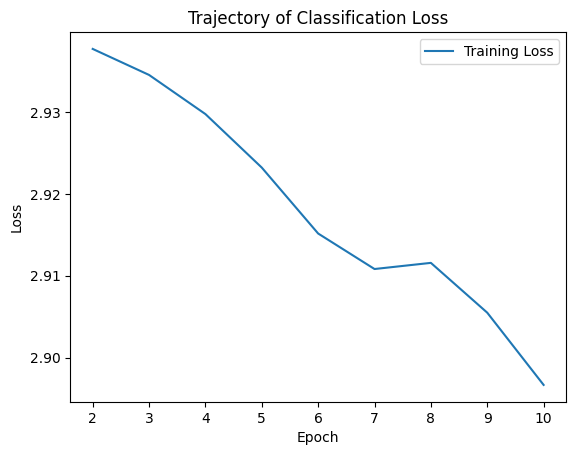

In [11]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Define the Dice Coefficient loss function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, predicted, target):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice_score = (2. * intersection + 1e-7) / (union + 1e-7)
        return 1 - dice_score

# Instantiate the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the Dice loss function
criterion = DiceLoss()

# Training loop with loss collection
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, cup_masks, disc_masks in train_loader:
        images, cup_masks, disc_masks = images.to(device), cup_masks.to(device), disc_masks.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, cup_masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if epoch != 0:  # Exclude loss from 0th epoch
        train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

print("Training finished!")

# Plot the trajectory of classification loss
plt.plot(range(2, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Trajectory of Classification Loss')
plt.legend()
plt.show()

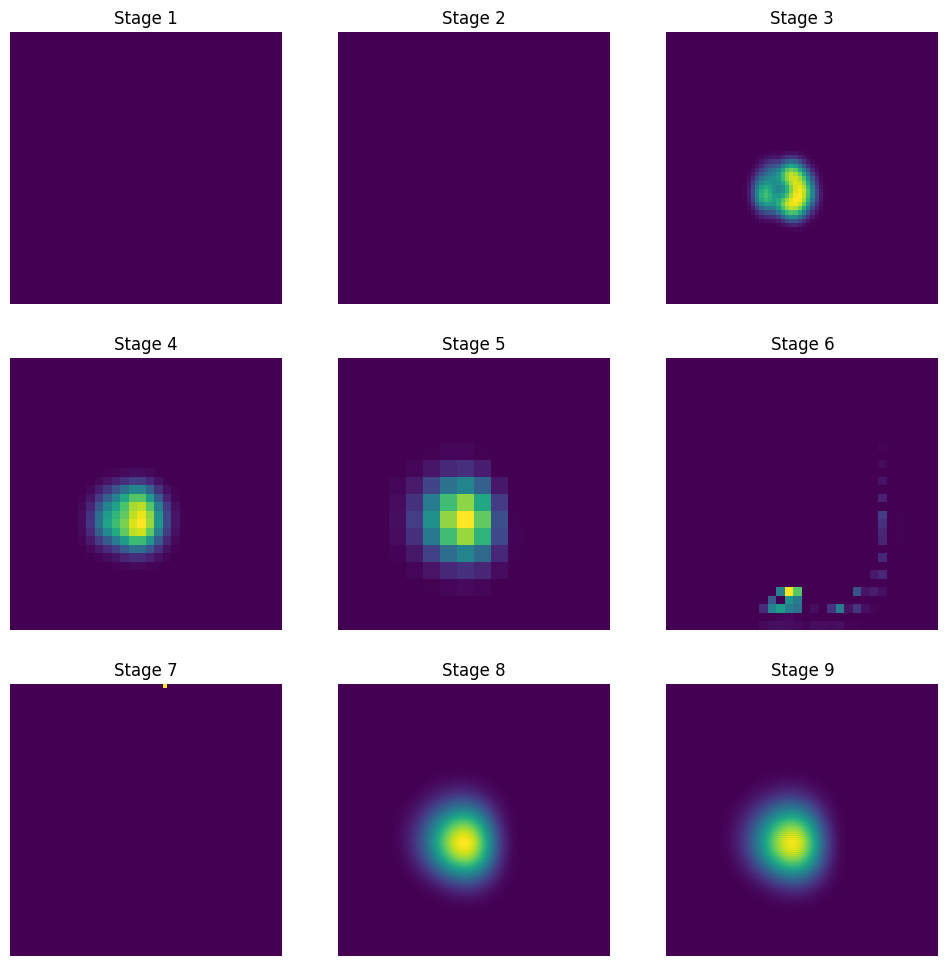

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Define a function to visualize feature maps for a specific image in a batch
def visualize_feature_maps(model, test_loader, image_index=7):
    # Set the model to evaluation mode
    model.eval()

    # Iterate over the test loader
    with torch.no_grad():
        for batch_index, (images, _, _) in enumerate(test_loader):
            if batch_index == 0:  # Visualize feature maps for the first batch only
                images = images.to(device)

                # Forward pass to get the feature maps at different stages
                feature_maps = []
                x = images
                xe11 = relu(model.e11(x))
                xe12 = relu(model.e12(xe11))
                feature_maps.append(xe12)  # Stage 1

                xp1 = model.pool1(xe12)
                xe21 = relu(model.e21(xp1))
                xe22 = relu(model.e22(xe21))
                feature_maps.append(xe22)  # Stage 2

                xp2 = model.pool2(xe22)
                xe31 = relu(model.e31(xp2))
                xe32 = relu(model.e32(xe31))
                feature_maps.append(xe32)  # Stage 3

                xp3 = model.pool3(xe32)
                xe41 = relu(model.e41(xp3))
                xe42 = relu(model.e42(xe41))
                feature_maps.append(xe42)  # Stage 4

                xp4 = model.pool4(xe42)
                xe51 = relu(model.e51(xp4))
                xe52 = relu(model.e52(xe51))
                feature_maps.append(xe52)  # Stage 5

                # Decoder stages
                xu1 = model.upconv1(xe52)
                xu11 = torch.cat([xu1, xe42], dim=1)
                xd11 = relu(model.d11(xu11))
                xd12 = relu(model.d12(xd11))
                feature_maps.append(xd12)  # Stage 6

                xu2 = model.upconv2(xd12)
                xu22 = torch.cat([xu2, xe32], dim=1)
                xd21 = relu(model.d21(xu22))
                xd22 = relu(model.d22(xd21))
                feature_maps.append(xd22)  # Stage 7

                xu3 = model.upconv3(xd22)
                xu33 = torch.cat([xu3, xe22], dim=1)
                xd31 = relu(model.d31(xu33))
                xd32 = relu(model.d32(xd31))
                feature_maps.append(xd32)  # Stage 8

                xu4 = model.upconv4(xd32)
                xu44 = torch.cat([xu4, xe12], dim=1)
                xd41 = relu(model.d41(xu44))
                xd42 = relu(model.d42(xd41))
                feature_maps.append(xd42)  # Stage 9

                # Plot the feature maps for the specified image
                fig, axes = plt.subplots(3, 3, figsize=(12, 12))
                for j, ax in enumerate(axes.flat):
                    ax.imshow(feature_maps[j][image_index, 0].cpu().numpy(), cmap='viridis')
                    ax.set_title(f"Stage {j+1}")
                    ax.axis('off')
                plt.show()

                break  # Break the loop after processing the first batch

# Assuming you have a test loader named `test_loader`
visualize_feature_maps(model, test_loader)


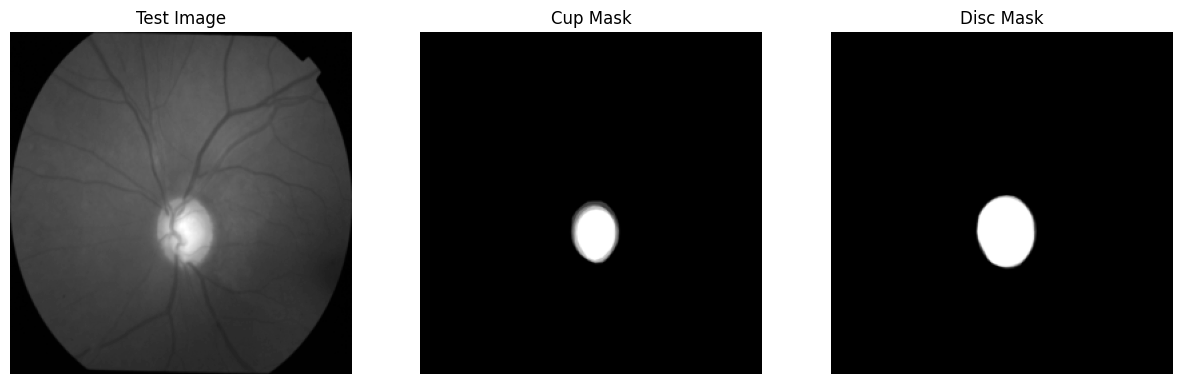

In [14]:
import matplotlib.pyplot as plt

# Select a random test image index
test_image_index = 0  # Change this to the desired index

# Get the corresponding image, cup mask, and disc mask from the test loader
for idx, (test_images, cup_masks, disc_masks) in enumerate(test_loader):
    if idx == test_image_index:
        # Select the first image from the batch
        test_image = test_images[0].squeeze().cpu().numpy()
        cup_mask = cup_masks[0].squeeze().cpu().numpy()
        disc_mask = disc_masks[0].squeeze().cpu().numpy()

        # Plot the image, cup mask, and disc mask
        plt.figure(figsize=(15, 5))

        # Plot the image
        plt.subplot(1, 3, 1)
        plt.imshow(test_image, cmap='gray')
        plt.title('Test Image')
        plt.axis('off')

        # Plot the cup mask
        plt.subplot(1, 3, 2)
        plt.imshow(cup_mask, cmap='gray')
        plt.title('Cup Mask')
        plt.axis('off')

        # Plot the disc mask
        plt.subplot(1, 3, 3)
        plt.imshow(disc_mask, cmap='gray')
        plt.title('Disc Mask')
        plt.axis('off')

        plt.show()
        break


In [ ]:
pip install torchmetrics

In [17]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import torchmetrics
import torchmetrics.functional as tmf

def dice_score(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice_score = (2. * intersection + 1e-7) / (union + 1e-7)
    return dice_score

def iou(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    iou_score = (intersection + 1e-7) / (union + 1e-7)
    return iou_score


def compute_metrics(predicted, target):
    # Apply threshold to predicted masks
    predicted = (predicted > 0.5).float()

    # Binarize the target tensor
    target = (target > 0.5).float()

    # Compute metrics
    dice_coefficient = dice_score(predicted, target)
    jaccard_similarity_index = iou(predicted, target)

    # Compute confusion matrix
    cm = tmf.confusion_matrix(predicted.view(-1), target.view(-1), num_classes=2, task='binary')

    # Compute accuracy, precision, recall, specificity, F1-score
    tn, fp, fn, tp = cm.view(-1)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-7)  # Adding epsilon to avoid division by zero
    recall = tp / (tp + fn + 1e-7)  # Adding epsilon to avoid division by zero
    specificity = tn / (tn + fp + 1e-7)  # Adding epsilon to avoid division by zero
    f1_score = (2 * precision * recall) / (precision + recall + 1e-7)  # Adding epsilon to avoid division by zero

    return dice_coefficient, jaccard_similarity_index, accuracy, precision, recall, specificity, f1_score, cm



def evaluate_model(model, dataloader, device):
    model.eval()
    total_dice_coefficient = 0.0
    total_jaccard_similarity_index = 0.0
    total_accuracy = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_specificity = 0.0
    total_f1_score = 0.0
    total_cm = None

    with torch.no_grad():
        for images, cup_masks, disc_masks in dataloader:
            images, cup_masks, disc_masks = images.to(device), cup_masks.to(device), disc_masks.to(device)

            outputs = model(images)

            # Evaluate segmentation outcomes for cup_masks
            dice_coefficient, jaccard_similarity_index, accuracy, precision, recall, specificity, f1_score, cm = compute_metrics(outputs, cup_masks)
            total_dice_coefficient += dice_coefficient.item()
            total_jaccard_similarity_index += jaccard_similarity_index.item()
            total_accuracy += accuracy
            total_precision += precision
            total_recall += recall
            total_specificity += specificity
            total_f1_score += f1_score
            if total_cm is None:
                total_cm = cm
            else:
                total_cm += cm

    num_batches = len(dataloader)
    avg_dice_coefficient = total_dice_coefficient / num_batches
    avg_jaccard_similarity_index = total_jaccard_similarity_index / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_precision = total_precision / num_batches
    avg_recall = total_recall / num_batches
    avg_specificity = total_specificity / num_batches
    avg_f1_score = total_f1_score / num_batches

    return avg_dice_coefficient, avg_jaccard_similarity_index, avg_accuracy, avg_precision, avg_recall, avg_specificity, avg_f1_score, total_cm


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate the model
avg_dice_coefficient, avg_jaccard_similarity_index, avg_accuracy, avg_precision, avg_recall, avg_specificity, avg_f1_score, total_cm = evaluate_model(model, test_loader, device)

# Print evaluation metrics
print(f"Average Dice Coefficient: {avg_dice_coefficient}")
print(f"Average Jaccard Similarity Index: {avg_jaccard_similarity_index}")
print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average Specificity: {avg_specificity}")
print(f"Average F1-Score: {avg_f1_score}")

# Print confusion matrix
print("Confusion Matrix:")
print(total_cm)

Average Dice Coefficient: 0.026735315565019846
Average Jaccard Similarity Index: 0.013552824733778834
Average Accuracy: 0.013552824966609478
Average Precision: 0.013552824966609478
Average Recall: 1.0
Average Specificity: 0.0
Average F1-Score: 0.02673531323671341
Confusion Matrix:
tensor([[      0, 3295718],
        [      0,   46618]], device='cuda:0')


##TASK-2

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetWithClassification(nn.Module):
    def __init__(self, n_class, n_channels=1):
        super().__init__()

        # Encoder
        # -------
        # input: 256x256x1
        self.e11 = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1) # output: 256x256x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 256x256x64

        # input: 256x256x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x128x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 128x128x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x128x128

        # input: 128x128x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 64x64x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x256

        # input: 64x64x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 32x32x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 32x32x512

        # input: 32x32x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 16x16x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 16x16x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

        # Classification layers
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(1024, 64, kernel_size=1)

        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=1)

        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=1)

        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=1)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv5 = nn.Conv2d(512, 1, kernel_size=1)

    def forward(self, x):

        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))

        xp1 = self.pool1(xe12)
        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))

        xp2 = self.pool2(xe22)
        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))

        xp3 = self.pool3(xe32)
        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))

        xp4 = self.pool4(xe42)
        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Classification layers
        x = torch.cat([xd42, xd32], dim=1)
        x = self.pool1(x)
        x = self.conv1(x)
        x = F.relu(x)

        x = torch.cat([x, xd22], dim=1)
        x = self.pool2(x)
        x = self.conv2(x)
        x = F.relu(x)

        x = torch.cat([x, xd12], dim=1)
        x = self.pool3(x)
        x = self.conv3(x)
        x = F.relu(x)

        x = torch.cat([x, xe52], dim=1)
        x = self.pool4(x)
        x = self.conv4(x)
        x = F.relu(x)

        x = self.global_avg_pool(x)
        classification_output = torch.sigmoid(self.conv5(x))

        return segmentation_output, classification_output


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model
model = UNetWithClassification(n_class=2, n_channels=1).to(device)

# Define the Dice Coefficient loss function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, predicted, target):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice_score = (2. * intersection + 1e-7) / (union + 1e-7)
        return 1 - dice_score


# Define loss function for segmentation task
segmentation_criterion = DiceLoss()

# Define loss function for classification task
classification_criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0

    # Iterate over the batches in the train_loader
    for images, masks, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        segmentation_output, classification_output = model(images)

        # Compute segmentation loss
        segmentation_loss = segmentation_criterion(segmentation_output, masks)

        # Compute classification loss
        classification_loss = classification_criterion(classification_output, labels)

        # Total loss
        loss = segmentation_loss + classification_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * images.size(0)

    # Print average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Training Loss: {epoch_loss}")